In [3]:
from more_itertools import distinct_permutations
import numpy as np
import scipy.spatial.distance as sp
import numba as nb
from numba import jit, njit

n = 6
s1 = 3
s2 = 3

# a = np.concatenate((np.ones(s1),np.zeros(n-s1)))
# b = np.concatenate((np.ones(s2),np.zeros(n-s2)))
# print(a,b)

# p_a = np.array(tuple(distinct_permutations(a)))
# p_b = np.array(tuple(distinct_permutations(b)))
# #print(p_a,"\n\n", p_b)

# p_aa = np.repeat(p_a, p_b.shape[0], axis=0)
# p_bb = np.tile(p_b, (p_a.shape[0],1))

# base = np.concatenate((p_aa, p_bb), axis=1)


def Base(n=6, s1=3, s2=3):
    up_state = np.concatenate((np.ones(s1),np.zeros(n-s1)))
    down_state = np.concatenate((np.ones(s2),np.zeros(n-s2)))
    
    all_up_states = np.array(tuple(distinct_permutations(up_state)))
    all_down_states = np.array(tuple(distinct_permutations(down_state)))
 
	#reshape and repeat or tile to get all possible combinations:
    up_repeated = np.repeat(all_up_states, all_down_states.shape[0], axis=0)
    down_repeated = np.tile(all_down_states, (all_up_states.shape[0], 1))
    
    return np.concatenate((up_repeated, down_repeated), axis=1)

In [4]:
def up(x):
    y = np.atleast_2d(x)
    return y[:, : y.shape[1]//2]

def down(x):
    y = np.atleast_2d(x)
    return y[:, y.shape[1]//2 : ]

def nn(x):
    return np.sum(up(x) * down(x), axis=1)

def diag(basis, i):
    return np.atleast_2d(basis)[:,i] * np.atleast_2d(basis)[:, 2*n//2 + i]

def Double(basis, i):
    return np.diag(diag(basis, i))

def DoubleSiteAvg(basis): return np.diag(np.mean(up(basis) * down(basis), axis=1))

def OpSz(basis, i): return np.diag((up(basis) - down(basis))[:, i])
def OpSzSz(basis, i, j): return OpSz(basis, i) @ OpSz(basis, j)

@jit
def norm(x): return np.sum(np.abs(x))

@jit
def Allowed_Hoppings(n=6):
    h_0n = np.arange(0, n)
    h_1n = np.arange(1,n+1) % n
    
    up_clockwise = np.stack((h_0n, h_1n)).T
    up_counter_clockwise = np.fliplr(up_clockwise)
    down_clockwise = up_clockwise + n
    down_counter_clockwise = up_counter_clockwise + n
    
    if n==2: #clockwise and counterclockwise are the same
        return np.vstack((up_clockwise, down_clockwise))
    
    return np.vstack((up_clockwise, up_counter_clockwise, down_clockwise, down_counter_clockwise))

def Allowed_Hoppings_single(n=6):
    h_0n = np.arange(0, n)
    h_1n = np.arange(1,n+1) % n
    
    up_clockwise = np.stack((h_0n, h_1n)).T
    up_counter_clockwise = np.flip(up_clockwise, axis=1)
    #down_clockwise = up_clockwise + n
    #down_counter_clockwise = up_counter_clockwise + n
    
    if n==2: #clockwise and counterclockwise are the same
        return np.vstack((up_clockwise))
    
    return np.vstack((up_clockwise, up_counter_clockwise))

In [18]:
@jit
def Hop_sign(x, i): return (-1)**np.sum(x[i+1 : ])

@jit
def HopTest(x, y, cre, anh): return norm(x-y) == 2.0 and x[cre]==1 and x[anh]==0 and y[cre]==0 and y[anh]==1

# @jit
# def HopTest_no(x, y, cre, anh): return x[cre]==1 and x[anh]==0 and y[cre]==0 and y[anh]==1

@jit
def HopTest_no(x, y, cre, anh): return x[cre] * y[anh]==1 and x[anh] + y[cre]==0

In [23]:
n=3
base = Base(n=n,s1=2,s2=1)

In [7]:
@jit(fastmath=True)
def H1(basis, n):
	hop = Allowed_Hoppings(n=n)
	H = np.zeros((basis.shape[0], basis.shape[0]))

	for cre, anh in hop:
		for bra in nb.prange(basis.shape[0]):
			for ket in nb.prange(basis.shape[0]):
				if HopTest(basis[bra], basis[ket], cre, anh):
					H[bra, ket] += Hop_sign(basis[bra], cre) * Hop_sign(basis[ket], anh)
	return H

In [8]:
# def H1_new(basis, n):
# 	a = sp.cdist(basis, basis, metric="cityblock")
# 	a = np.where(a==2, 1, 0)

# 	b = np.prod(np.array([sp.cdist(base, base, lambda u,v:  4*Hop_sign(u,i) * Hop_sign(v,j) if HopTest_no(u,v,i,j) else 1) for i,j in Allowed_Hoppings(n=n)]), axis=0)
# 	b = np.where(b > 1, 1, np.where(b < -1, -1, 0))
 
# 	return a*b

In [9]:
@njit(fastmath=True,parallel=True)
def eucl_naive(A,B, ii, jj):
    assert A.shape[1]==B.shape[1]
    C=np.empty((A.shape[0],B.shape[0]),A.dtype)
    
    for i in nb.prange(A.shape[0]):
        for j in range(B.shape[0]):
            C[i,j] = 4*Hop_sign(A[i,:],ii) * Hop_sign(B[j,:],jj) if HopTest_no(A[i,:],B[j,:],ii,jj) else 1
    return C

In [10]:
@njit(fastmath=True,parallel=True)
def eucl(A,B, ii, jj):
    assert A.shape[1]==B.shape[1]
    C=np.empty((A.shape[0],B.shape[0]),A.dtype)
    
    for i in nb.prange(A.shape[0]):
        for j in range(B.shape[0]):
            C[i,j] = 4*Hop_sign(A[i,:],ii) * Hop_sign(B[j,:],jj) if HopTest(A[i,:],B[j,:],ii,jj) else 1
    return C

In [11]:
@jit(forceobj=True)
def H1_new(basis, n):
	a = sp.cdist(basis, basis, metric="cityblock")
	a = np.where(a==2, 1, 0)

	b = np.prod(np.array([eucl_naive(basis, basis, i, j) for i, j in Allowed_Hoppings(n=n)]), axis=0)
	b = np.where(b > 1, 1, np.where(b < -1, -1, 0))
 
	return a*b

In [81]:
n=6
base = Base(n=n,s1=1,s2=2)

In [32]:
%%timeit
H = H1(base, n=n)
#H

890 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
#%%timeit
H_ = H1(base, n=n)
H_

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [30]:
#%%timeit
H_new = H1_new(base, n=n)
#H_new

In [26]:
#%%timeit
H_new = H1_new(base, n=n)
H_new

array([[ 0,  1,  1,  1,  0,  0, -1,  0,  0],
       [ 1,  0,  1,  0,  1,  0,  0, -1,  0],
       [ 1,  1,  0,  0,  0,  1,  0,  0, -1],
       [ 1,  0,  0,  0,  1,  1,  1,  0,  0],
       [ 0,  1,  0,  1,  0,  1,  0,  1,  0],
       [ 0,  0,  1,  1,  1,  0,  0,  0,  1],
       [-1,  0,  0,  1,  0,  0,  0,  1,  1],
       [ 0, -1,  0,  0,  1,  0,  1,  0,  1],
       [ 0,  0, -1,  0,  0,  1,  1,  1,  0]])

In [21]:
%%timeit
H_new = H1_new(base, n=n)
#H_new

456 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
np.sum(np.abs(H_) - np.abs(H_new))

0.0

In [88]:
def H2(basis): return np.diag(nn(basis))

@jit
def H(H1, H2, u): return u * H2 + H1

In [83]:
H2_ = H2(base)

In [79]:
H1

CPUDispatcher(<function H1 at 0x7f68cf2a1790>)

In [101]:
H_what = H(H_, H2_, 10)

In [40]:
import matplotlib.pyplot as plt

In [86]:
@jit
def s(Ht, Hu):
	return np.array([np.linalg.eigvalsh(H(Ht, Hu, u)) for u in np.linspace(0,20, num=40)])

In [90]:
%%timeit
s(H_,H2_)

85.4 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


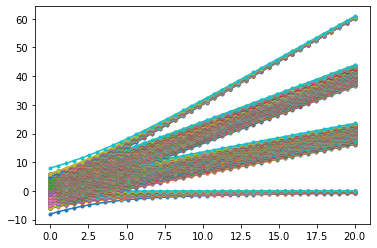

In [105]:
plt.plot(np.linspace(0,20, num=40), eigs, ".-");

In [110]:
import numba as nb

In [66]:
n=3
base = Base(n=n,s1=2,s2=1)
base

array([[0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1., 0.],
       [0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 0.]])

In [78]:
OpSzSz(base, 0, 2)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [37]:
base

array([[0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1., 0.],
       [0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 0.]])

In [73]:
import ipywidgets as widgets

f = widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.01,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)



In [74]:
f

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', max=10.0, readout_format='.1f…

In [72]:
np.linspace(*f.value, num=int(np.subtract(*f.value[::-1]).round(2) / f.step)+1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [51]:
np.abs(np.subtract(*f.value))/f.step

6.9

In [67]:
np.subtract(*f.value[::-1]).round(2)

4.2